# PIC16B HW3: Web Development
- Author: Skylar Lyu
- Submission Date: Feb 17, 2023

This blog post is a tutorial for simple web development using `flask`. The app we’re going to build is a simple message bank. It should do two things:
1. Allow the user to **submit** messages to the bank.
2. Allow the user to **view** a sample of the messages currently stored in the bank.

To do this, we create an `app.py` to deploy functions, the `html` files to design templates, and a `style.css` file to format the webpage.

*The Github repository link is https://github.com/skylar0104007/pic16b-hw3-web-development-flask*

## 0. Install Libraries

In [ ]:
from flask import Flask
from flask import render_template, g, url_for, request
import sqlite3

## 1. Enable Submissions
First, create a `submit` template with three user interface elements:
1. A text box for submitting a message.
2. A text box for submitting the name of the user.
3. A “submit” button. 

You may find it helpful to put navigation links (the top two links at the top of the screen) inside a template called `base.html`, then have the `submit.html` template extend `base.html`. For example, the `base.html from mnist demo` has the navigation links and also specifies where the header and content blocks would go. Then, other templates like `submit.html` just has to write what would go inside `header` and `content` instead of repeating everything that’s already in the `base.html` template. There are more examples to extend from `flask` and `jinja`.

**Useful links**: 
- `base.html from mnist demo`: https://github.com/HarlinLee/pic16b-mnist-demo/blob/main/templates/base.html
- `submit.html`: https://github.com/HarlinLee/pic16b-mnist-demo/blob/main/templates/submit.html
- `flask`: https://flask.palletsprojects.com/en/2.2.x/tutorial/templates/#register
- `jinja`: https://jinja.palletsprojects.com/en/3.1.x/templates/#template-inheritance

### `base.html`

This is the main template that establishes a basic format so that `submit.html` and `view.html` can extend from. 

In [ ]:
<!doctype html>
<link rel="stylesheet" href="{{ url_for('static', filename='style.css') }}">
<title>{% block title %}{% endblock %} PIC16B HW3 </title>
<nav>
  <h1>A Simple Message Bank</h1>
  <!-- <b>Navigation:</b> -->
  <ul>
    <li><a href="{{ url_for('submit')}}">Submit a message</a></li>
    <li><a href="{{ url_for('view') }}">View messages</a></li>
  </ul>
</nav>
<section class="content">
  <header>
    {% block header %}{% endblock %}
  </header>
  {% block content %}{% endblock %}
</section>

To produce the main page of the website, run the following code: 

In [ ]:
app = Flask(__name__)

@app.route('/')
def main():
    return render_template("base.html")

### `submit.html`

This template allows and reads in 2 entries: `message` and `name`. If the two entries are not empty, it will prompt a `success` message; otherwise, it prompts an `error` message. Conditions for these two messages will be introduced later in an `if` statement of the `insert_message` function. 
- Remember to specify the input names of the elements to facilitate the use of `request.form['<name>']` in later steps. 

In [ ]:
{% extends 'base.html' %}

{% block header %}
  <h1>{% block title %}Submit{% endblock %}</h1>
{% endblock %}

{% block content %}
  <form method="post">
      <label for="message">Your message:</label>
      <br>
      <input type="text" name="message" id="message">
      <br>
      <label for="handle">Your name or handle:</label>
      <input type="text" name="handle" id="handle">
      <br>
      <input type="submit" value="Submit message">
  </form>

  {% if success %}
    <br>
    Thanks for submitting a message!
  {% endif %}

  {% if error %}
    <br>
    Please fill in both blanks. 
  {% endif %}
  
{% endblock %}

See below a screenshot of the webpage layout of `submit.html`. 

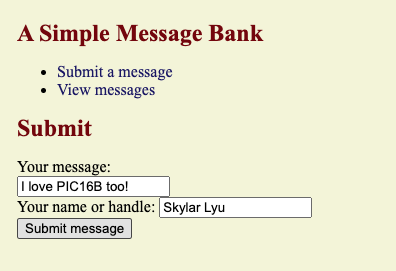

In [1]:
from IPython import display
display.Image("submit.jpg")

Now, write two Python functions for database management in a new file `app.py` (you can also write them in a separate `.py` file and import them into `app.py`).

- **`get_message_db()` should handle creating the database of messages.**

1. Check whether there is a database called `message_db` in the `g` attribute of the app. If not, then connect to that database, ensuring that the connection is an attribute of `g`. To do this last step, write a line like do `g.message_db = sqlite3.connect("messages_db.sqlite")`

2. Check whether a table called `messages` exists in `message_db`, and create it if not. For this purpose, the SQL command `CREATE TABLE IF NOT EXISTS` is helpful. Give the table an `id` column (integer), a `handle` column (text), and a `message` column (text).

3. Return the connection `g.message_db`.

In [ ]:
#function to handle creating the database of messages
def get_message_db():
    
    #check whether there is a database called `message_db` 
    #in the g attribute of the app
    try:
        return g.message_db
    
    #otherwise connect to that database
    #ensuring that the connection is an attribute of g
    except:
        g.message_db=sqlite3.connect("message_db.sqlite")
        
        #write the SQL query
        #NOTE: please include the commas and semicolon!!!
        cmd=\
        """
        CREATE TABLE IF NOT EXISTS message (
            id INTEGER PRIMARY KEY,
            handle TEXT NOT NULL,
            message TEXT NOT NULL);
        """
        
        #execute and return
        cursor=g.message_db.cursor()
        cursor.execute(cmd)
        
        return g.message_db

- **`insert_message(request)` should handle inserting a user message into the database of messages.**

1. Extract the `message` and the `handle` from `request`. You’ll need to ensure that your `submit.html` template creates these fields from user input by appropriately specifying the `name` of the input elements. For example: `<input type="text" name="message" id="message">` is what I used in my template to ensure that `request.form["message"]` contained the `message` input by the user. You should then return the `message` and the `handle`.

2. Using a cursor, insert the message into the `message` database. Remember that you’ll need to provide an `ID number`, the `handle`, and the `message` itself. You’ll need to write a SQL command to perform the insertion.

     - *Note*: when working directly with SQL commands, it is necessary to run `db.commit()` after inserting a row into db in order to ensure that your row insertion has been saved.
     - You should ensure that the ID number of each message is unique. One way to do this is by setting the ID number of a message equal to one plus the current number of rows in `message_db`.
     - Don’t forget to close the database connection within the function!

In [ ]:
#function to handle inserting a user message into the database of messages
def insert_message(request):
    
    #extract values from existing database
    db=get_message_db()
    cursor=db.cursor()
    
    #use id_num to ensure the ID number of each message is unique
    nrows=cursor.execute("SELECT * FROM message")
    id_num=len(nrows.fetchall())+1
    
    handle=request.form['handle']
    message=request.form['message']
    #if both message and handle are not empty, insert them to message database
    if message and handle:
        cursor.execute('INSERT INTO message VALUES (?,?,?)',(id_num,handle,message))
        db.commit()  
    
    #remember to close connection and save space
    db.close()

**Finally, write a function to `render_template()` the `submit.html` template.**

Since this page will both transmit and receive data, you should ensure that it supports both `POST` and `GET` methods, and give it appropriate behavior in each one. 

- In the `GET` case, you can just render the `submit.html` template with no other parameters. 
- In the `POST` case, you should call `insert_message()` (and then render the `submit.html` template). Maybe it would be nice to add a small note thanking the user for their submission?

In [ ]:
@app.route('/submit/', methods=['POST','GET']) #support both methods
def submit():
    
    #if GET, render the submit.html with no other parameters
    if request.method=='GET':
        return render_template('submit.html')
    
    #if POST, call insert_message and then render the submit.html
    else:
        
        try: #if successfully insert: id for each message is unique
            insert_message(request)
            
            #if both name and message are texts, prompt success message
            if request.form['handle'] and request.form['message']:
                return render_template('submit.html', success=True)
            
            #if either name or message is not text, prompt error message
            else:
                return render_template('submit.html', error=True)

        except: #if fail to insert, prompt error message too
            return render_template('submit.html', error=True)

## 2. Viewing Random Submissions

- **Write a function called `random_messages(n)` to return a collection of `n` random messages from the `message_db`, or fewer if necessary.** 

Don’t forget to close the database connection within the function!

In [ ]:
#function to return n random messages from the message_db, or fewer if necessary
def random_messages(n=5): #set a default n=5
    db=get_message_db()
    cursor=db.cursor()
    
    #if default n > number of unique messages
    #print all unique messages in database
    #otherwise still print n random messages
    nrows=cursor.execute("SELECT * FROM message")
    total_rows=len(nrows.fetchall())
    if n>total_rows:
        n=total_rows
    
    #print n random pairs of name and message from message database
    cmd=f"""SELECT handle, message FROM message ORDER BY RANDOM() LIMIT {n}"""
    cursor.execute(cmd)
    
    #store name and message and return as tuples
    fetched_messages=cursor.fetchall()
    db.close()
    
    return fetched_messages

### `view.html` 

This template displays the messages extracted from `random_messages()`.

I took advantage of the fact that Jinja tags support looping (so I looped over the messages), and I also used the fact that Jinja tags support indexing of objects (so if `m` is a tuple of user handle and message `m[0]` contains the handle and `m[1]` contains the message).

If `fetched_messages` is not empty, print in the {message} *-{name}* format. Otherwise, print an error message. 

In [ ]:
{% extends 'base.html' %}

{% block header %}
  <h2>{% block title %}Some Cool Messages{% endblock %}</h2>
{% endblock %}

{% block content %}

{% if fetched_messages %}
  {% for m in fetched_messages %}
    <br>
    {{ m[1] }}
    <br>
    <i>- {{ m[0] }}</i>
    <br>
  {% endfor %}

{% else %} No messages yet! 
{% endif %}

{% endblock %}

See below a screenshot of the webpage layout of `view.html`. 

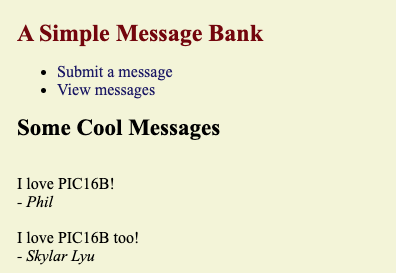

In [2]:
from IPython import display
display.Image("view.jpg")

- **Finally, write a function to render your `view.html` template.**

This function should first call `random_messages()` to grab some random messages (I chose a cap of 5), and then pass these messages as an argument to `render_template()`.

In [ ]:
@app.route('/view/')
def view():
    return render_template('view.html',fetched_messages=random_messages())

## 3. Customize Your App

Write some CSS to customize your app! At minimum, you should
- Incorporate a non-default font.
- Use color in some way.

Feel free to add additional CSS (and modify your templates if necessary) in order to give your app a personal feel.

In [ ]:
html {
    font-family: Times New Roman;
    background-color: Beige;
    padding: 1rem;
}

h1 {
    color: Maroon;
    margin: 1rem 0;
    text-align: left;
}

h2 {
    margin: 1rem 0;
    font-size: 23px;
}

a {
    color: MidnightBlue;
    text-decoration: none;
}

#### Volià!